## Demo of steady state temperature diffusion in an annulus
### Plot radial temperature and check against an simple analytic solution

In [1]:
import underworld as uw
import glucifer
import numpy as np

uw.matplotlib_inline()
import matplotlib.pyplot as plt
plt.ion()


In [2]:
annulus = uw.mesh._FeMesh_Annulus(elementRes=(20,100), radialLengths=(3.0,6.), angularExtent=(0.0,360.0))
tField = uw.mesh.MeshVariable(annulus, nodeDofCount=1)


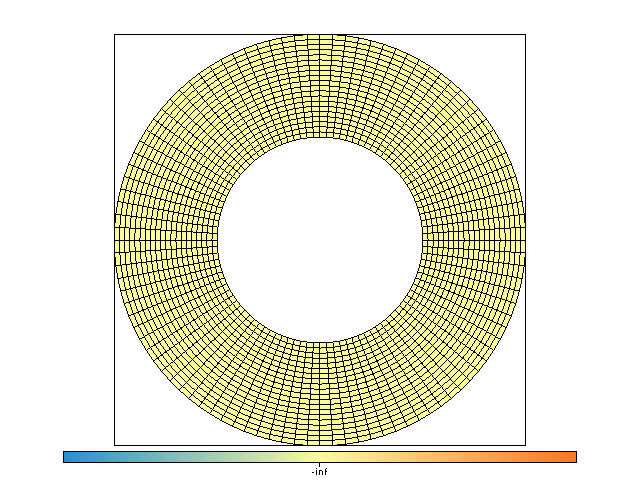

In [3]:
fig = glucifer.Figure()
fig.append(glucifer.objects.Mesh(annulus))
fig.append(glucifer.objects.Surface(annulus, tField, onMesh=True))
fig.show()

In [4]:
outer = annulus.specialSets["MaxI_VertexSet"]
inner = annulus.specialSets["MinI_VertexSet"]
tMin = 5.0
tMax = 10.0
tField.data[inner.data] = tMax
tField.data[outer.data] = tMin

In [5]:
tBC = uw.conditions.DirichletCondition( variable=tField, indexSetsPerDof=(inner+outer))

In [6]:
ssSLE = uw.systems.SteadyStateHeat(tField,fn_diffusivity=1.0, conditions=tBC)

In [7]:
ssSolver = uw.systems.Solver(ssSLE)

In [8]:
ssSolver.solve()


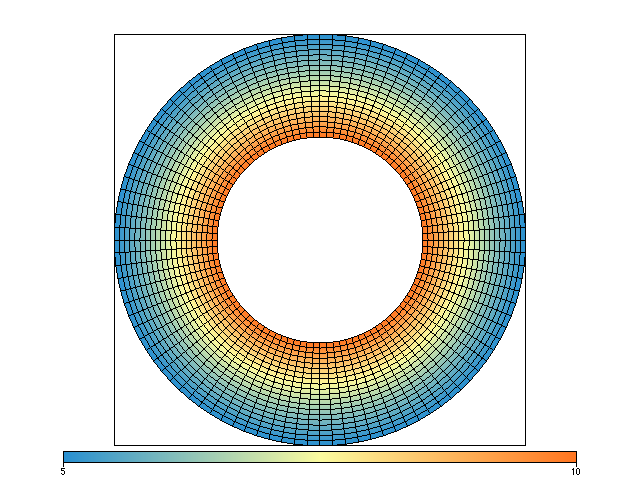

In [9]:
fig.show()

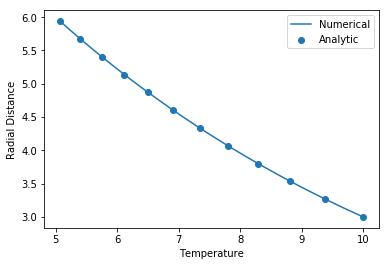

In [10]:
## The following only works in SERIAL!

if uw.nProcs() > 1:
    raise RuntimeError("The analysis part of this model doesn't work in parallel")

## Plot radial temperature and check against an analytic solution

nP = 100
# The 0.99 is required here as the mesh is not perfectly cylindrical
arrR = np.linspace(annulus.radialLengths[0],annulus.radialLengths[1]*0.99,nP)
                          
arrT = np.zeros(nP)
arrError = np.zeros(nP)
arrAnalytic = np.zeros(nP)

# Largest error at this angle (still not large)
theta = np.pi / 2.

for i in range(nP):
    pos = tuple(np.array( [ np.cos(theta),np.sin(theta)]) * (arrR[i]))
    t = tField.evaluate(pos)
    tAn = np.log( (arrR[i])/annulus.radialLengths[0]) / np.log(annulus.radialLengths[1]/annulus.radialLengths[0]) * (tMin-tMax)  + tMax
    
    arrT[i] = t
    arrAnalytic[i] = tAn
    arrError[i] = abs(t-tAn)

plotEvery = 9
plt.scatter(arrAnalytic[::plotEvery],arrR[::plotEvery],label="Analytic")

plt.plot(arrT,arrR,label="Numerical")
plt.ylabel("Radial Distance")
plt.xlabel("Temperature")
plt.legend()

Text(0.5,0,u'Percentage Error')

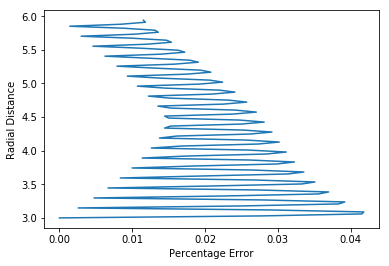

In [11]:
# Plot radial error, as a percentage of the max. temp difference
plt.plot(arrError / (tMax-tMin) * 100.,arrR)
plt.ylabel("Radial Distance")
plt.xlabel("Percentage Error")